In [0]:
import os
import numpy as np

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 3.5MB/s 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def load_from_drive(name, id):
    module = drive.CreateFile({'id': id})
    module.GetContentFile(name)

file_list = drive.ListFile({'q': "'1CBd-myDP_NKbTovfcwYsam_0H06Bl2Q_' in parents and trashed=false"}).GetList()
for file in file_list:
    if file['title'][-3:] == '.py':
        print("load file: {}, id: {}".format(file['title'], file['id']))
        load_from_drive(file['title'], file['id'])

from ReNetLayer import *
from ReduceImbalance import *
from HilbertLayer import *
from ModifiedReNetLayer import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

load file: ReNetLayer.py, id: 1oohHESF2OGoErRZoEftPAW3m5IXtcwGG
load file: ModifiedReNetLayer.py, id: 11ylcxUGgwS5Yzf_8zRIUzz9a_c--lznh
load file: ReduceImbalance.py, id: 1YG1ZkJfhrJeUNGGruk5iCsCKgK3ukM3H
load file: HilbertLayer.py, id: 1FuFE0OpWp0BFxNFAYGBLmdLXcHkNOSYS
load file: HilbertCurve.py, id: 1ABiyahqt1c1NkR2XIDyfvHyqHeCDkAn8
load file: CommandsGenerator.py, id: 1o4ow1uW7-8cgiAm1fwTF7xyM9piB_ZQ2
load file: ModelIfc.py, id: 1jsKb1mjhEIbAUaFW7BOZ0br8SNGXbr-p
load file: RandomSearch.py, id: 1YXiIrn0osAW4wBBAsYxwAb8BeftQmWyB
load file: KerasAdapter.py, id: 1cTv-dqemRA9j1xgd2TFVUNwtdqXqP3Hk


In [0]:
!pip install kaggle
!mkdir .kaggle
!mkdir ~/.kaggle

import json
token = {"username":"jedrzejkozal","key":"b75eb41911b09455300af4e40d2cb9f0"}
with open('.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp .kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{.}

- path is now set to: {.}


In [0]:
!mkdir flowers
!kaggle datasets download -d alxmamaev/flowers-recognition -p ./flowers --force

!unzip flowers/flowers-recognition.zip -d flowers/

 98% 221M/225M [00:03<00:00, 68.0MB/s]
100% 225M/225M [00:03<00:00, 76.7MB/s]
Archive:  flowers/flowers-recognition.zip
   creating: flowers/flowers/
   creating: flowers/flowers/daisy/
  inflating: flowers/flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/flowers/daisy/10

In [0]:
num_samples = 4323
num_classes = 5
datagen = ImageDataGenerator()
iterator = datagen.flow_from_directory("flowers/flowers", batch_size=num_samples, target_size=(32, 32))
x_data, y_data = next(iterator)
print("before undersampling: ", x_data.shape, y_data.shape)
del datagen
del iterator

def normalize(matrix):
    mu = np.mean(matrix, axis=0)
    std = np.std(matrix, axis=0)
    return (matrix - mu) / std

x_data = normalize(x_data)

Found 4323 images belonging to 5 classes.
before undersampling:  (4323, 32, 32, 3) (4323, 5)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7, stratify=y_data) #it was test_size=0.3, random_state=42, stratify=None

x_train, y_train = undersample_to_lowest_cardinality_class(x_data, y_data)
print("after undersampling: ", x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

datagen = ImageDataGenerator(width_shift_range=[-2.0, 0.0, 2.0],
                            horizontal_flip=True,
                            vertical_flip=False)
datagen.fit(x_train)

after undersampling:  (3670, 32, 32, 3) (3670, 5)
(865, 32, 32, 3) (865, 5)


In [0]:
def get_reNet(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.00000001)):
    model = Sequential()

    reNet_hidden_size = 256
    model.add(ReNetLayer([[2, 2]], reNet_hidden_size,
        use_dropout=True, dropout_rate=0.1))
    model.add(ReNetLayer([[2, 2]], reNet_hidden_size,
        use_dropout=True, dropout_rate=0.1))
    model.add(ReNetLayer([[2, 2]], reNet_hidden_size,
        use_dropout=True, dropout_rate=0.1))

    model.add(Flatten())
    fully_conn_hidden_size = 4096
    model.add(Dense(fully_conn_hidden_size, activation='relu', activity_regularizer=dense_reg))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=softmax_reg))

    model.compile(loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['categorical_accuracy']
        )
    
    return model

def get_modif_reNet(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.0000001)):
    model = Sequential()

    reNet_hidden_size = 256
    model.add(HilbertLayer())
    model.add(ModifiedReNetLayer(4, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.2))
    model.add(ModifiedReNetLayer(4, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.2))
    model.add(ModifiedReNetLayer(4, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.2))

    model.add(Flatten())
    fully_conn_hidden_size = 1024
    model.add(Dense(fully_conn_hidden_size, activation='relu', activity_regularizer=dense_reg))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=softmax_reg))

    model.compile(loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['categorical_accuracy']
        )
    
    return model

def get_conv(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.00000001), conv_reg=None):
    model = Sequential()
    
    model.add(Conv2D(128, kernel_size=(4, 4), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    #model.add(Conv2D(64, kernel_size=(4, 4), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=(4, 4), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    #model.add(Conv2D(64, kernel_size=(4, 4), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(2, 2), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    #model.add(Conv2D(128, kernel_size=(2, 2), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=(2, 2), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu', activity_regularizer=dense_reg))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=softmax_reg))

    model.compile(loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['categorical_accuracy'])
    
    return model

In [0]:
model = get_reNet(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.00000001))

In [0]:
model = get_modif_reNet(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.0000001))

In [0]:
model = get_conv() #lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.00000001))

In [0]:
x_single_ex = x_train[0:1]
y_single_ex = y_train[0:1]
model.fit(x_single_ex, y_single_ex, epochs=1)
model.summary()

Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 1.0000 - categorical_accuracy: 0.0000e+00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 32, 32, 128)       6272      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 8, 8, 128)         512       
______________________________

In [0]:
batch_size = 32
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=50,
        steps_per_epoch=np.ceil(x_train.shape[0] / batch_size),
        validation_data=(x_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1)
            ]
    )

loss, acc = tuple(model.evaluate(x_test, y_test, batch_size=batch_size))
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/50
115/115 [==============================] - 74s 643ms/step - loss: 0.3182 - categorical_accuracy: 0.8903 - val_loss: 0.2788 - val_categorical_accuracy: 0.9249
Epoch 2/50
115/115 [==============================] - 73s 636ms/step - loss: 0.2391 - categorical_accuracy: 0.9216 - val_loss: 0.2873 - val_categorical_accuracy: 0.9237
Epoch 3/50
115/115 [==============================] - 73s 634ms/step - loss: 0.2314 - categorical_accuracy: 0.9254 - val_loss: 0.2892 - val_categorical_accuracy: 0.9249
Epoch 4/50
115/115 [==============================] - 73s 636ms/step - loss: 0.1951 - categorical_accuracy: 0.9341 - val_loss: 0.3090 - val_categorical_accuracy: 0.9168
Epoch 5/50
115/115 [==============================] - 73s 637ms/step - loss: 0.2094 - categorical_accuracy: 0.9314 - val_loss: 0.4793 - val_categorical_accuracy: 0.8983
Epoch 6/50
115/115 [==============================] - 73s 633ms/step - loss: 0.1846 - categorical_accuracy: 0.9362 - val_loss: 0.2801 - val_categorical_acc

KeyboardInterrupt: ignored

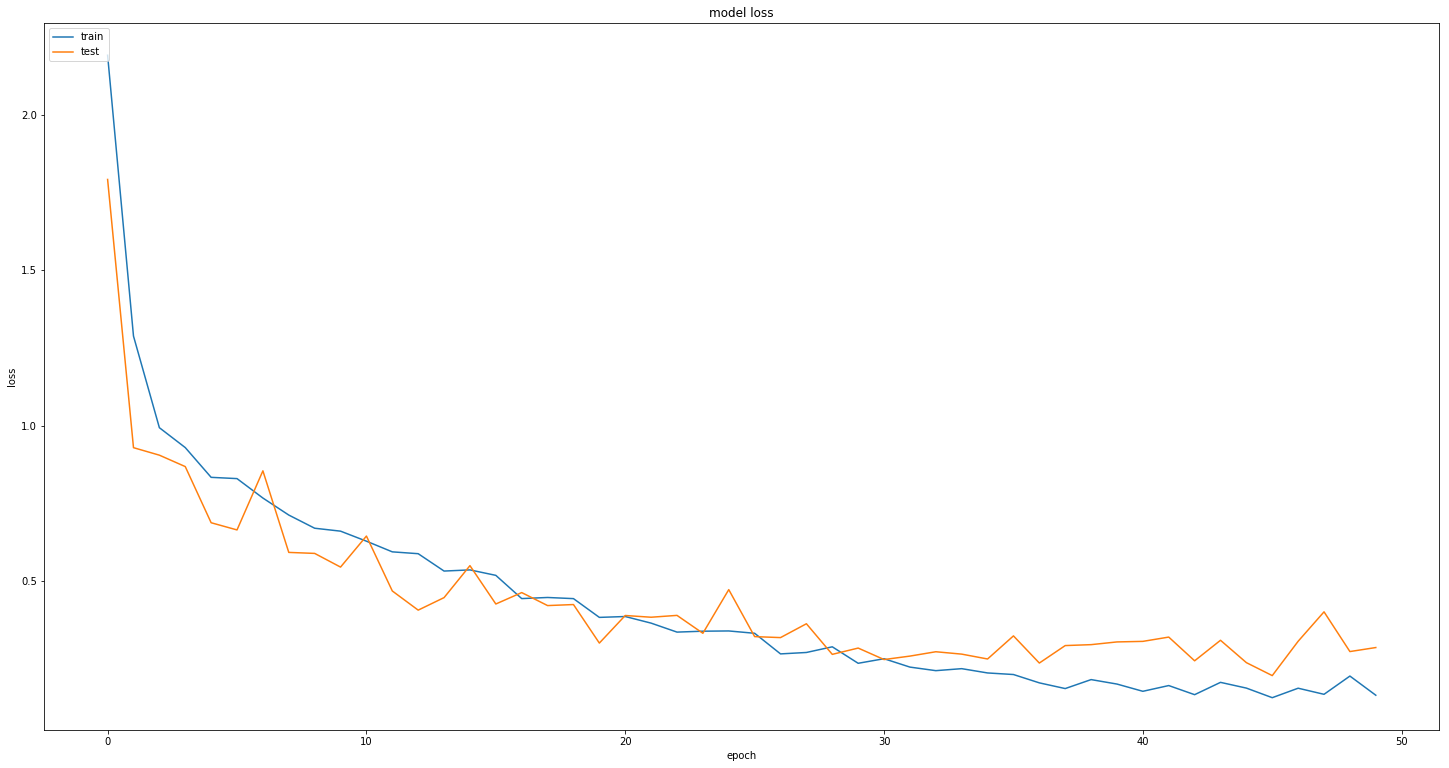

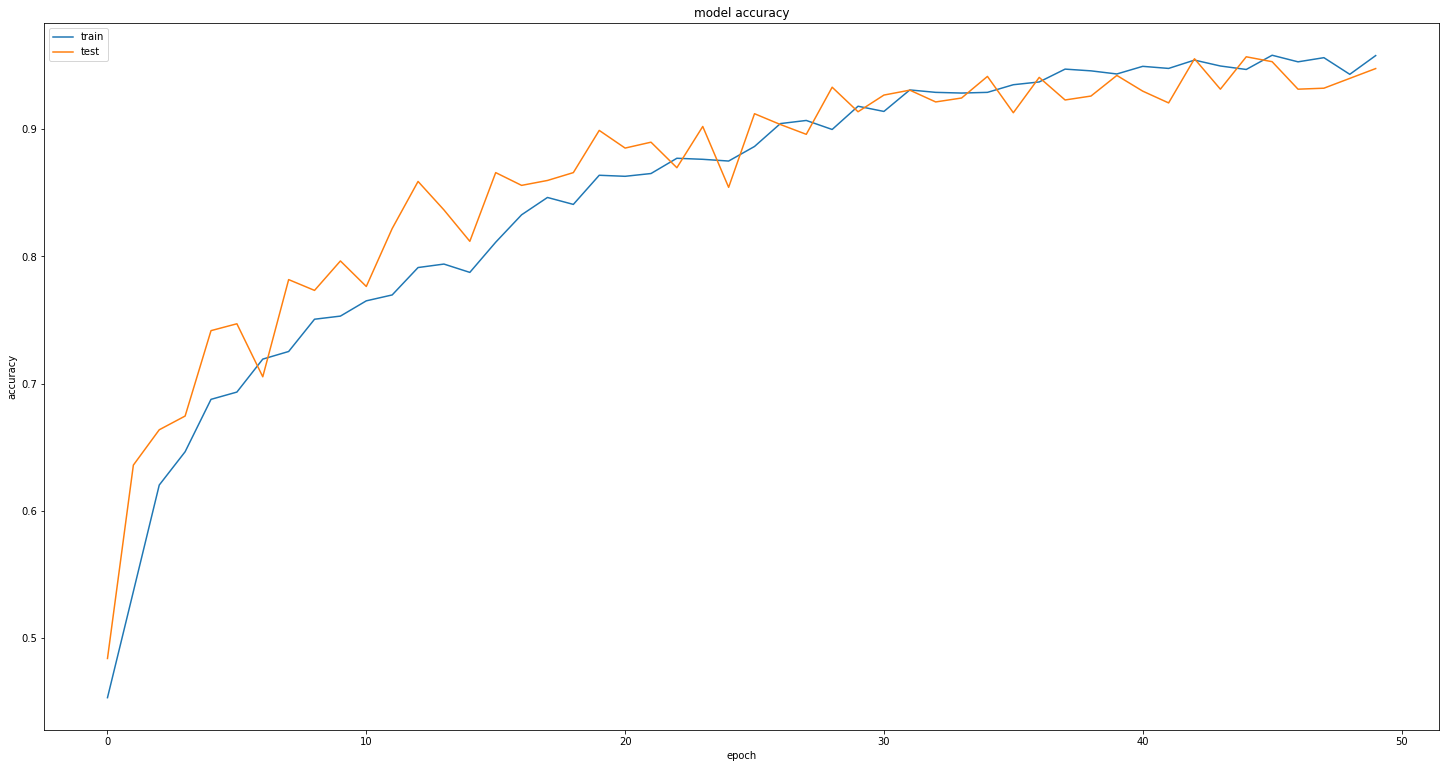

In [0]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.figure(figsize=(25,13))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.figure(figsize=(25,13))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
batch_size = 32
x_single_ex = x_train[0:1]
y_single_ex = y_train[0:1]

for lr in [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]:
    model = get_conv(lr=lr)
    
    model.fit(x_single_ex, y_single_ex, epochs=1)
    model.summary()
    
    model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)])

    loss, acc = tuple(model.evaluate(x_test, y_test, batch_size=batch_size))
    print("lr = ", lr)
    print("test loss", loss)
    print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 2.3342 - categorical_accuracy: 0.0000e+00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 32, 32, 16)        784       
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 16)        4112      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 16, 16, 32)        8224      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 32)        16416     
________________________________

KeyboardInterrupt: ignored

# ***Cros validation 5 Folds***

In [0]:
x = x_data
y = y_data
y = convert_from_one_hot_to_labels(y)

print("all data: ", x.shape, y.shape)

def get_fold(fold_num):
    fold_num = fold_num-1 #indexing from 0
    x_train = x[train_indexes[fold_num]]
    y_train = y[train_indexes[fold_num]]
    x_test = x[test_indexes[fold_num]]
    y_test = y[test_indexes[fold_num]]

    x_train, y_train = undersample_to_lowest_cardinality_class(x_train, y_train)
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    return x_train, y_train, x_test, y_test

all data:  (4323, 32, 32, 3) (4323,)


In [0]:
from sklearn.model_selection import StratifiedKFold

def get_splits(x, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    train_indexes = []
    test_indexes = []
    for train_index, test_index in skf.split(x, y):
        print("train_index: ", train_index)
        print("test_index: ", test_index)
        train_indexes.append(train_index)
        test_indexes.append(test_index)
        
    return train_indexes, test_indexes

train_indexes, test_indexes = get_splits(x, y)

train_index:  [   0    1    2 ... 4319 4320 4322]
test_index:  [  13   15   19   22   25   38   41   44   45   52   54   55   62   64
   77   79   83   84   89   95   97  107  110  112  114  118  129  131
  138  141  147  148  159  167  170  173  176  181  188  195  201  205
  207  208  214  215  216  218  220  221  236  242  245  247  250  252
  253  254  255  258  259  266  273  279  283  288  290  292  293  295
  323  330  333  334  336  342  350  351  352  366  369  373  374  382
  383  394  396  404  405  413  414  427  429  431  432  447  458  464
  465  468  469  471  496  504  506  508  522  530  531  545  547  553
  561  566  568  569  573  574  577  579  581  582  584  586  597  611
  615  625  627  632  636  637  641  645  647  650  652  658  659  661
  667  680  681  684  687  693  694  700  710  714  716  718  723  729
  734  740  744  749  752  759  765  785  786  797  798  805  810  814
  824  825  826  828  829  831  839  841  843  845  857  860  863  871
  874  884  88

In [0]:
def test_model_on_fold(model, x_train, y_train, x_test, y_test):
    x_train_single_ex = x_train[0:1]
    y_train_single_ex = y_train[0:1]
    model.fit(x_train_single_ex, y_train_single_ex, epochs=1)
    
    datagen = ImageDataGenerator(width_shift_range=[-2.0, 0.0, 2.0])
    datagen.fit(x_train)

    batch_size = 32
    model.fit(x_train, y_train, 
                        batch_size=batch_size,
                        epochs=50,
                        #steps_per_epoch=np.ceil(x_train.shape[0] / batch_size),
                        validation_data=(x_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True),
                                   ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)])
    loss, acc = tuple(model.evaluate(x_test, y_test, batch_size=batch_size))
    return loss, acc

# Fold 1

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(1)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 16s 16s/step - loss: 1.6048 - categorical_accuracy: 1.0000
Train on 2935 samples, validate on 866 samples
Epoch 1/50
2935/2935 [==============================] - 380s 129ms/step - loss: 1.3568 - categorical_accuracy: 0.4109 - val_loss: 1.3541 - val_categorical_accuracy: 0.4042
Epoch 2/50
2935/2935 [==============================] - 365s 124ms/step - loss: 1.2571 - categorical_accuracy: 0.4562 - val_loss: 1.2970 - val_categorical_accuracy: 0.4261
Epoch 3/50
2935/2935 [==============================] - 366s 125ms/step - loss: 1.2290 - categorical_accuracy: 0.4750 - val_loss: 1.2977 - val_categorical_accuracy: 0.4365
Epoch 4/50
2935/2935 [==============================] - 368s 125ms/step - loss: 1.2157 - categ

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 13s 13s/step - loss: 1.6447 - categorical_accuracy: 0.0000e+00
Train on 2935 samples, validate on 866 samples
Epoch 1/50
2935/2935 [==============================] - 56s 19ms/step - loss: 1.5951 - categorical_accuracy: 0.3935 - val_loss: 1.5557 - val_categorical_accuracy: 0.3741
Epoch 2/50
2935/2935 [==============================] - 49s 17ms/step - loss: 1.3594 - categorical_accuracy: 0.4641 - val_loss: 1.3874 - val_categorical_accuracy: 0.4480
Epoch 3/50
2935/2935 [==============================] - 50s 17ms/step - loss: 1.3196 - categorical_accuracy: 0.4746 - val_loss: 1.2768 - val_categorical_accuracy: 0.4919
Epoch 4/50
2935/2935 [==============================] - 50s 17ms/step - loss: 1.2536 - categorical_accuracy: 0.4889 - val_loss: 1.4317 - val_categorical_accuracy: 0.4538
Epoch 5/50
2935/2935 [==============================] - 50s 17ms/step - loss: 1.2138 - categorical_accuracy: 0.5036 - val_loss: 1.2431 - val_categorical_accuracy

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 1.3793 - categorical_accuracy: 0.0000e+00
Train on 2935 samples, validate on 866 samples
Epoch 1/50
2935/2935 [==============================] - 62s 21ms/step - loss: 2.4024 - categorical_accuracy: 0.4521 - val_loss: 2.6464 - val_categorical_accuracy: 0.4319
Epoch 2/50
2935/2935 [==============================] - 60s 20ms/step - loss: 1.4293 - categorical_accuracy: 0.5455 - val_loss: 1.2557 - val_categorical_accuracy: 0.5600
Epoch 3/50
2935/2935 [==============================] - 60s 20ms/step - loss: 1.0166 - categorical_accuracy: 0.6228 - val_loss: 1.1175 - val_categorical_accuracy: 0.5901
Epoch 4/50
2935/2935 [==============================] - 60s 21ms/step - loss: 0.8291 - categorical_accuracy: 0.6879 - val_loss: 1.0844 - val_categorical_accuracy: 0.6155
Epoch 5/50
2935/2935 [==============================] - 60s 20ms/step - loss: 0.7073 - categorical_accuracy: 0.7397 - val_loss: 1.1749 - val_categorical_accuracy: 

# Fold 2

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(2)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 11s 11s/step - loss: 1.6102 - categorical_accuracy: 0.0000e+00
Train on 2935 samples, validate on 866 samples
Epoch 1/50
2935/2935 [==============================] - 103s 35ms/step - loss: 1.3378 - categorical_accuracy: 0.4191 - val_loss: 1.3244 - val_categorical_accuracy: 0.4122
Epoch 2/50
2935/2935 [==============================] - 96s 33ms/step - loss: 1.2483 - categorical_accuracy: 0.4596 - val_loss: 1.3399 - val_categorical_accuracy: 0.4099
Epoch 3/50
2935/2935 [==============================] - 97s 33ms/step - loss: 1.2314 - categorical_accuracy: 0.4807 - val_loss: 1.3256 - val_categorical_accuracy: 0.4157
Epoch 4/50
2935/2935 [==============================] - 96s 33ms/step - loss: 1.1938 - categori

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 15s 15s/step - loss: 1.6523 - categorical_accuracy: 0.0000e+00
Train on 2935 samples, validate on 866 samples
Epoch 1/50
2935/2935 [==============================] - 172s 59ms/step - loss: 1.5448 - categorical_accuracy: 0.3949 - val_loss: 1.3865 - val_categorical_accuracy: 0.4099
Epoch 2/50
2935/2935 [==============================] - 162s 55ms/step - loss: 1.3461 - categorical_accuracy: 0.4617 - val_loss: 1.2628 - val_categorical_accuracy: 0.4423
Epoch 3/50
2935/2935 [==============================] - 165s 56ms/step - loss: 1.2556 - categorical_accuracy: 0.5009 - val_loss: 1.3674 - val_categorical_accuracy: 0.4342
Epoch 4/50
2935/2935 [==============================] - 165s 56ms/step - loss: 1.2231 - categorical_accuracy: 0.5070 - val_loss: 1.3105 - val_categorical_accuracy: 0.4596
Epoch 5/50
2935/2935 [==============================] - 164s 56ms/step - loss: 1.1993 - categorical_accuracy: 0.5135 - val_loss: 1.2426 - val_categorical_acc

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 2.4874 - categorical_accuracy: 0.0000e+00
Train on 2935 samples, validate on 866 samples
Epoch 1/50
2935/2935 [==============================] - 64s 22ms/step - loss: 2.1742 - categorical_accuracy: 0.4477 - val_loss: 1.9935 - val_categorical_accuracy: 0.5427
Epoch 2/50
2935/2935 [==============================] - 61s 21ms/step - loss: 1.3727 - categorical_accuracy: 0.5595 - val_loss: 1.0757 - val_categorical_accuracy: 0.5866
Epoch 3/50
2935/2935 [==============================] - 61s 21ms/step - loss: 0.9539 - categorical_accuracy: 0.6572 - val_loss: 0.9619 - val_categorical_accuracy: 0.6467
Epoch 4/50
2935/2935 [==============================] - 61s 21ms/step - loss: 0.8170 - categorical_accuracy: 0.6964 - val_loss: 1.1604 - val_categorical_accuracy: 0.6120
Epoch 5/50
2935/2935 [==============================] - 61s 21ms/step - loss: 0.6855 - categorical_accuracy: 0.7455 - val_loss: 1.0503 - val_categorical_accuracy: 

# Fold 3

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(3)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 13s 13s/step - loss: 1.5997 - categorical_accuracy: 1.0000
Train on 2935 samples, validate on 865 samples
Epoch 1/50
2935/2935 [==============================] - 106s 36ms/step - loss: 1.3425 - categorical_accuracy: 0.4136 - val_loss: 1.3182 - val_categorical_accuracy: 0.4266
Epoch 2/50
2935/2935 [==============================] - 99s 34ms/step - loss: 1.2488 - categorical_accuracy: 0.4600 - val_loss: 1.3205 - val_categorical_accuracy: 0.3931
Epoch 3/50
2935/2935 [==============================] - 97s 33ms/step - loss: 1.2115 - categorical_accuracy: 0.4835 - val_loss: 1.2921 - val_categorical_accuracy: 0.4335
Epoch 4/50
2935/2935 [==============================] - 97s 33ms/step - loss: 1.2145 - categorical_accuracy: 0.4801 - val_loss: 1.2736 - val_categorical_accuracy: 0.4335
Epoch 5/50
2935/2935 [==============================] - 100s 34ms/step - loss: 1.1889 - categorical_accuracy: 0.4859 - val_loss: 1.2405 - val_categorical_accuracy: 

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 16s 16s/step - loss: 1.6833 - categorical_accuracy: 0.0000e+00
Train on 2935 samples, validate on 865 samples
Epoch 1/50
2935/2935 [==============================] - 173s 59ms/step - loss: 1.6129 - categorical_accuracy: 0.3734 - val_loss: 1.5819 - val_categorical_accuracy: 0.4185
Epoch 2/50
2935/2935 [==============================] - 166s 57ms/step - loss: 1.3768 - categorical_accuracy: 0.4440 - val_loss: 1.4589 - val_categorical_accuracy: 0.4370
Epoch 3/50
2935/2935 [==============================] - 165s 56ms/step - loss: 1.2631 - categorical_accuracy: 0.4818 - val_loss: 1.2894 - val_categorical_accuracy: 0.4775
Epoch 4/50
2935/2935 [==============================] - 166s 57ms/step - loss: 1.1966 - categorical_accuracy: 0.5087 - val_loss: 1.3310 - val_categorical_accuracy: 0.4590
Epoch 5/50
2935/2935 [==============================] - 165s 56ms/step - loss: 1.1719 - categorical_accuracy: 0.5298 - val_loss: 1.2676 - val_categorical_acc

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 3.3332 - categorical_accuracy: 0.0000e+00
Train on 2935 samples, validate on 865 samples
Epoch 1/50
2935/2935 [==============================] - 62s 21ms/step - loss: 2.4148 - categorical_accuracy: 0.4307 - val_loss: 1.8661 - val_categorical_accuracy: 0.5145
Epoch 2/50
2935/2935 [==============================] - 62s 21ms/step - loss: 1.3897 - categorical_accuracy: 0.5458 - val_loss: 1.0360 - val_categorical_accuracy: 0.5931
Epoch 3/50
2935/2935 [==============================] - 61s 21ms/step - loss: 1.0229 - categorical_accuracy: 0.6160 - val_loss: 1.0235 - val_categorical_accuracy: 0.6150
Epoch 4/50
2935/2935 [==============================] - 60s 21ms/step - loss: 0.8473 - categorical

# Fold 4

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(4)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 15s 15s/step - loss: 1.6071 - categorical_accuracy: 1.0000
Train on 2935 samples, validate on 865 samples
Epoch 1/50
2935/2935 [==============================] - 109s 37ms/step - loss: 1.3557 - categorical_accuracy: 0.4099 - val_loss: 1.3107 - val_categorical_accuracy: 0.4243
Epoch 2/50
2935/2935 [==============================] - 98s 33ms/step - loss: 1.2813 - categorical_accuracy: 0.4552 - val_loss: 1.2936 - val_categorical_accuracy: 0.4405
Epoch 3/50
2935/2935 [==============================] - 98s 33ms/step - loss: 1.2427 - categorical_accuracy: 0.4586 - val_loss: 1.2258 - val_categorical_accuracy: 0.4902
Epoch 4/50
2935/2935 [==============================] - 98s 33ms/step - loss: 1.2109 - categorical_accuracy: 0.4842 - val_loss: 1.2300 - val_categorical_accuracy: 0.4624
Epoch 5/50
2935/2935 [==============================] - 99s 34ms/step - loss: 1.2024 - categorical_accuracy: 0.4920 - val_loss: 1.2039 - val_categorical_accuracy: 0

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 10s 10s/step - loss: 1.5325 - categorical_accuracy: 1.0000
Train on 2935 samples, validate on 865 samples
Epoch 1/50
2935/2935 [==============================] - 172s 59ms/step - loss: 1.6002 - categorical_accuracy: 0.3891 - val_loss: 1.3562 - val_categorical_accuracy: 0.4382
Epoch 2/50
2935/2935 [==============================] - 165s 56ms/step - loss: 1.3954 - categorical_accuracy: 0.4487 - val_loss: 1.2917 - val_categorical_accuracy: 0.4428
Epoch 3/50
2935/2935 [==============================] - 166s 57ms/step - loss: 1.2953 - categorical_accuracy: 0.4794 - val_loss: 1.3172 - val_categorical_accuracy: 0.4370
Epoch 4/50
2935/2935 [==============================] - 166s 57ms/step - loss: 1.2140 - categoric

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.3604 - categorical_accuracy: 1.0000
Train on 2935 samples, validate on 865 samples
Epoch 1/50
2935/2935 [==============================] - 62s 21ms/step - loss: 2.2759 - categorical_accuracy: 0.4566 - val_loss: 2.5523 - val_categorical_accuracy: 0.4277
Epoch 2/50
2935/2935 [==============================] - 61s 21ms/step - loss: 1.3226 - categorical_accuracy: 0.5479 - val_loss: 1.2498 - val_categorical_accuracy: 0.5630
Epoch 3/50
2935/2935 [==============================] - 61s 21ms/step - loss: 0.9292 - categorical_accuracy: 0.6630 - val_loss: 1.1113 - val_categorical_accuracy: 0.5954
Epoch 4/50
2935/2935 [==============================] - 61s 21ms/step - loss: 0.8011 - categorical_accuracy: 0.6968 - val_loss: 1.2351 - val_categorical_accuracy: 0.5757
Epoch 5/50
2935/2935 [==============================] - 62s 21ms/step - loss: 0.6978 - categorical_accuracy: 0.7380 - val_loss: 1.0838 - val_categorical_accuracy: 0.60

# Fold 5

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(5)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 16s 16s/step - loss: 1.6105 - categorical_accuracy: 0.0000e+00
Train on 2940 samples, validate on 861 samples
Epoch 1/50
2940/2940 [==============================] - 370s 126ms/step - loss: 1.3555 - categorical_accuracy: 0.4116 - val_loss: 1.3235 - val_categorical_accuracy: 0.4297
Epoch 2/50
2940/2940 [==============================] - 357s 121ms/step - loss: 1.2545 - categorical_accuracy: 0.4660 - val_loss: 1.2899 - val_categorical_accuracy: 0.4251
Epoch 3/50
2940/2940 [==============================] - 356s 121ms/step - loss: 1.2352 - categorical_accuracy: 0.4762 - val_loss: 1.2837 - val_categorical_accuracy: 0.4390
Epoch 4/50
2940/2940 [==============================] - 354s 121ms/step - loss: 1.2156 - c

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 13s 13s/step - loss: 1.6946 - categorical_accuracy: 0.0000e+00
Train on 2940 samples, validate on 861 samples
Epoch 1/50
2940/2940 [==============================] - 173s 59ms/step - loss: 1.5048 - categorical_accuracy: 0.4143 - val_loss: 1.4409 - val_categorical_accuracy: 0.3961
Epoch 2/50
2940/2940 [==============================] - 165s 56ms/step - loss: 1.3061 - categorical_accuracy: 0.4891 - val_loss: 1.4804 - val_categorical_accuracy: 0.4321
Epoch 3/50
2940/2940 [==============================] - 165s 56ms/step - loss: 1.2489 - categorical_accuracy: 0.5020 - val_loss: 1.4707 - val_categorical_accuracy: 0.4262
Epoch 4/50
2940/2940 [==============================] - 166s 57ms/step - loss: 1.2537 - categorical_accuracy: 0.4973 - val_loss: 1.5060 - val_categorical_accuracy: 0.4367
Epoch 5/50
2940/2940 [==============================] - 165s 56ms/step - loss: 1.2032 - categorical_accuracy: 0.5153 - val_loss: 1.3283 - val_categorical_acc

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 3.3332 - categorical_accuracy: 0.0000e+00
Train on 2940 samples, validate on 861 samples
Epoch 1/50
2940/2940 [==============================] - 61s 21ms/step - loss: 2.2374 - categorical_accuracy: 0.4429 - val_loss: 2.0557 - val_categorical_accuracy: 0.4750
Epoch 2/50
2940/2940 [==============================] - 61s 21ms/step - loss: 1.3086 - categorical_accuracy: 0.5588 - val_loss: 1.2399 - val_categorical_accuracy: 0.5807
Epoch 3/50
2940/2940 [==============================] - 60s 21ms/step - loss: 0.9550 - categorical_accuracy: 0.6429 - val_loss: 1.1452 - val_categorical_accuracy: 0.5877
Epoch 4/50
2940/2940 [==============================] - 60s 21ms/step - loss: 0.8087 - categorical_accuracy: 0.6925 - val_loss: 1.1130 - val_categorical_accuracy: 0.6423
Epoch 5/50
2940/2940 [==============================] - 62s 21ms/step - loss: 0.6720 - categorical_accuracy: 0.7517 - val_loss: 1.1465 - val_categorical_accuracy: 